In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
mpl.rcParams["axes.unicode_minus"] = False
from sklearn.metrics import classification_report
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.chdir(r'C:\Users\82104\DM\project')

## 데이터

In [3]:
con = pd.read_csv("data_for_classification.csv", encoding='UTF8', index_col = 0)
con.head()

,GAS_STATION,DISTRICT,DONG,LATITUDE,LONGITUDE,AREA,ESTATE,DIST_EASTDC,DIST_WESTDC,DIST_KOREADC,POP100,POP500,POP1000,SCHOOL,APART,MARKET
0,현대오일뱅크(주) 직영소월길주유소,용산구,후암동,37.554409,126.977735,245.0,8280000.0,8.970251,13.202286,11.678968,166,4465,15660,5,1,58
1,선익상사(주) 동자동주유소,용산구,동자동,37.550201,126.972418,711.0,18850000.0,9.568763,12.593357,11.494239,349,7404,25467,9,2,6
2,현대오일뱅크㈜ 직영갈월동주유소,용산구,갈월동,37.547029,126.972228,700.0,15050000.0,9.713120,12.454393,11.199948,251,7069,26924,9,1,22
3,서계주유소,용산구,서계동,37.552366,126.968994,1010.0,10330000.0,9.772973,12.403577,11.855362,102,8374,30288,5,2,4
4,㈜영원에너지 풍기주유소,용산구,원효로2가,37.535589,126.962709,519.0,13300000.0,11.006969,11.272070,10.639303,186,5401,27394,9,6,20


In [4]:
con.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469 entries, 0 to 468
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GAS_STATION   469 non-null    object 
 1   DISTRICT      469 non-null    object 
 2   DONG          469 non-null    object 
 3   LATITUDE      469 non-null    float64
 4   LONGITUDE     469 non-null    float64
 5   AREA          469 non-null    float64
 6   ESTATE        469 non-null    float64
 7   DIST_EASTDC   469 non-null    float64
 8   DIST_WESTDC   469 non-null    float64
 9   DIST_KOREADC  469 non-null    float64
 10  POP100        469 non-null    int64  
 11  POP500        469 non-null    int64  
 12  POP1000       469 non-null    int64  
 13  SCHOOL        469 non-null    int64  
 14  APART         469 non-null    int64  
 15  MARKET        469 non-null    int64  
dtypes: float64(7), int64(6), object(3)
memory usage: 62.3+ KB


we will use only numerical data for EDA.

In [5]:
data = con.loc[:, ['AREA', 'ESTATE', 'DIST_EASTDC', 'DIST_WESTDC', 'DIST_KOREADC','POP1000','SCHOOL','APART','MARKET']]
data

,AREA,ESTATE,DIST_EASTDC,DIST_WESTDC,DIST_KOREADC,POP1000,SCHOOL,APART,MARKET
0,245.0,8280000.0,8.970251,13.202286,11.678968,15660,5,1,58
1,711.0,18850000.0,9.568763,12.593357,11.494239,25467,9,2,6
2,700.0,15050000.0,9.713120,12.454393,11.199948,26924,9,1,22
3,1010.0,10330000.0,9.772973,12.403577,11.855362,30288,5,2,4
4,519.0,13300000.0,11.006969,11.272070,10.639303,27394,9,6,20
...,...,...,...,...,...,...,...,...,...
464,1366.0,4205000.0,12.288585,26.954691,25.294460,12421,4,1,0
465,1640.7,4395000.0,11.849594,26.639204,24.849744,18592,4,1,0
466,271.0,5671000.0,10.807711,25.756175,23.746627,28101,0,0,4
467,815.0,5380000.0,11.191130,26.466958,24.267332,30149,3,1,2


## 데이터 탐색

### Data Summarization

In [6]:
info_data = (pd.DataFrame({"Features" : data.columns, "Non-Null Count" : data.count(), 
                               "Null Count" : data.isnull().sum(), "Datatypes" : data.dtypes}).sort_values(by = "Datatypes")\
                              .reset_index(drop = True))
stats_data = data.describe(include = "all").T.reset_index()
total = pd.merge(info_data, stats_data, right_on = "index", left_on = "Features", how = "inner")\
                .drop(columns = ["index", "count"]).round(0)
total = total.fillna(0)
total.style.bar(subset = ["mean", "std", "min", "25%", "50%", "75%", "max"], axis = 1)\
    .format({'mean' : "{:20,.0f}", 'std' : "{:20,.0f}", 'min' : "{:20,.0f}", '25%' : "{:20,.0f}", '50%' : "{:20,.0f}",
             '75%' : "{:20,.0f}", 'max' : "{:20,.0f}"})\
    .set_properties(**{"background-color" : "#f9f9f9", "color" : "black", "border-color" : "white"}).hide_index()

Features,Non-Null Count,Null Count,Datatypes,mean,std,min,25%,50%,75%,max
POP1000,469,0,int64,"28,901","11,836",5,"20,791","30,288","37,483","61,836"
SCHOOL,469,0,int64,3,2,0,1,2,4,14
APART,469,0,int64,5,6,0,1,4,7,54
MARKET,469,0,int64,4,6,0,1,3,5,59
AREA,469,0,float64,806,474,85,509,711,965,"3,778"
ESTATE,469,0,float64,"9,526,646","6,602,571","27,600","5,674,000","7,444,000","11,270,000","43,500,000"
DIST_EASTDC,469,0,float64,11,6,0,7,11,16,27
DIST_WESTDC,469,0,float64,15,8,0,8,16,22,30
DIST_KOREADC,469,0,float64,13,5,0,10,13,17,26


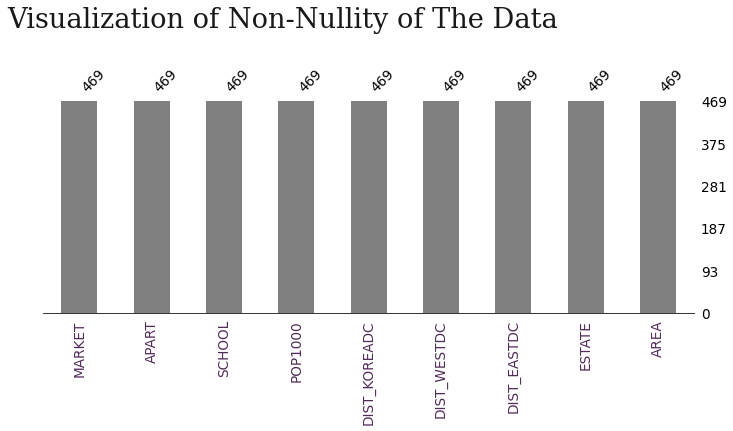

In [7]:
def color_count(df):

    color = []
    nd = pd.DataFrame(df.isna().sum() == 0)
    nd.reset_index(inplace = True)
    nd.columns = ["col", "bool"]
    cut_nd = nd[nd["bool"] == True]
    cut_nd2 = nd[nd["bool"] == False]

    for i in range(len(cut_nd)):
    
        color.append("grey")
    
    for j in range(len(cut_nd2)):
    
        color.append("#fe346e")
    
    return color

fig, ax = plt.subplots(figsize = (12, 4), dpi = 70)
fig.patch.set_facecolor("white")

ax.set_facecolor("white")

msno.bar(data, sort = "descending", color = color_count(data), ax = ax, fontsize = 14, labels = "off", filter = "top")
ax.text(-1, 1.35, "Visualization of Non-Nullity of The Data", {"font": "Serif","size" : 28, "color": "black"}, 
        alpha = 0.9)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha = "center", 
                   **{ "weight": "normal", "color": "#512b58"}, alpha = 1)
ax.set_yticklabels("")
ax.spines["bottom"].set_visible(True)

fig.show()

There is no null values in dataset.

### Remove Outliers

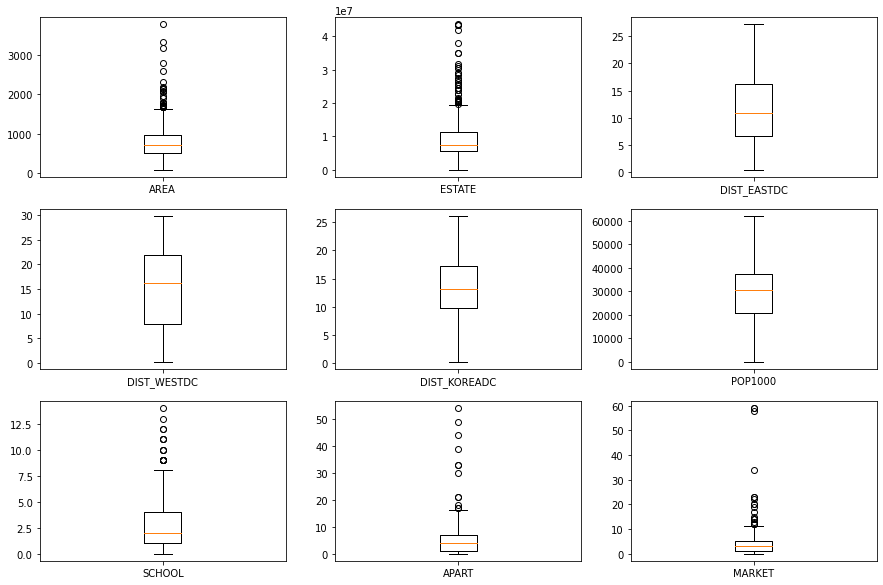

In [8]:
fig = plt.figure(figsize = (15, 10))

for i, n in enumerate(data.iloc[:, :].columns):
    
    plt.subplot(int(len(data.iloc[:, :].columns) / 3), 3, i + 1)
    plt.boxplot(data[n], labels = [n])

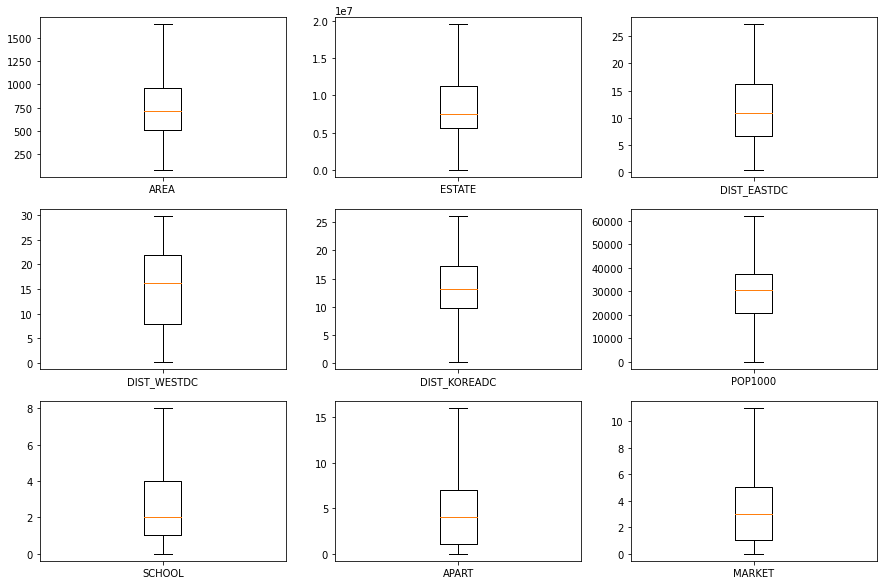

In [9]:
def outlier_trans(df):
    
    idx = 0
    
    for _, col in enumerate(df.columns):
        
        q75, q25 = np.percentile(df[col], [75, 25])
        iqr = q75 - q25
        ind = df[col][(df[col] > q75 + 1.5 * iqr) | (df[col] < q25 - 1.5 * iqr)].index
    
        if (len(ind) == 0) | (df[col].dtypes == "object"):
            
            idx += 1
    
        else:
            
            for _, n in enumerate(ind):
    
                if df.iloc[n, idx] > q75:
        
                    df.iloc[n, idx] = q75
        
                else:
        
                    df.iloc[n, idx] = q25
            
            idx += 1
    
X_con = data.copy()
outlier_trans(X_con)

fig = plt.figure(figsize = (15, 10))

for i, n in enumerate(data.iloc[:, :].columns):
    
    plt.subplot(int(len(X_con.iloc[:, :].columns) / 3), 3, i + 1)
    plt.boxplot(X_con[n], labels = [n])

In this case, Replace outliers(under Q1, over Q3) with Max & Min values.

### 단변수 탐색 : 수치형 변수

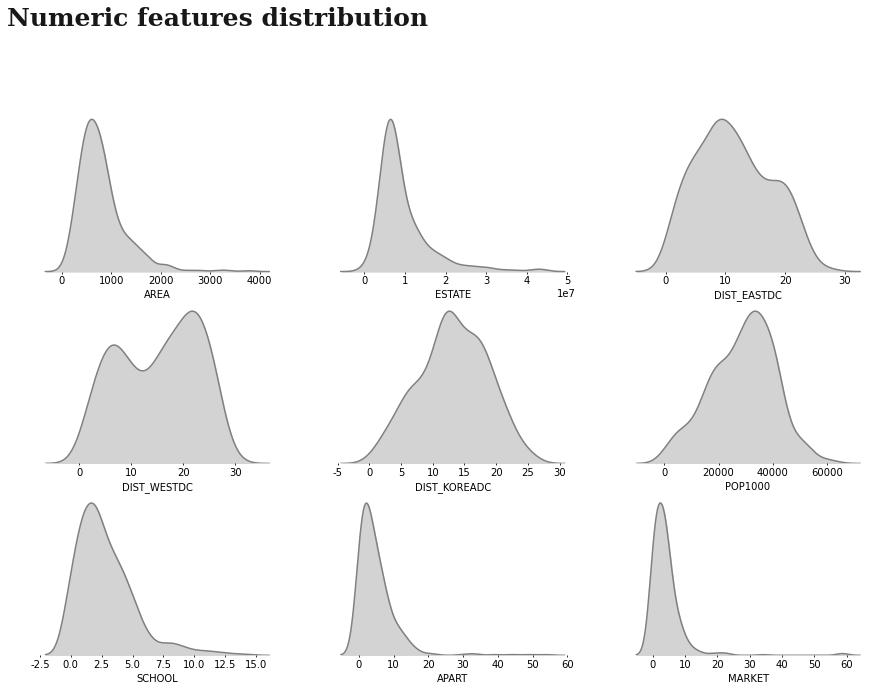

In [10]:
fig =  plt.figure(figsize = (15, 10))
g = fig.add_gridspec(3, 3)
g.update(wspace = 0.2, hspace = 0.2)
ax0 = fig.add_subplot(g[0, 0])
ax1 = fig.add_subplot(g[0, 1])
ax2 = fig.add_subplot(g[0, 2])
ax3 = fig.add_subplot(g[1, 0])
ax4 = fig.add_subplot(g[1, 1])
ax5 = fig.add_subplot(g[1, 2])
ax6 = fig.add_subplot(g[2, 0])
ax7 = fig.add_subplot(g[2, 1])
ax8 = fig.add_subplot(g[2, 2])
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]



for ax in axes:
    
    ax.tick_params(axis = "x", labelsize = 10, which = "major", direction = "out", pad = 2, length = 1.5)
    ax.tick_params(axis = "y", colors = "black")
    ax.axes.get_yaxis().set_visible(False)
    
    for loc in ["left", "right", "top", "bottom"]:
        ax.spines[loc].set_visible(False)

num_cols = data.dtypes[(data.dtypes == "int64") | (data.dtypes == "float64")].index

sns.kdeplot(x = data[num_cols[0]], fill = True, alpha = 1, ax = ax0, color = "lightgrey")
sns.kdeplot(x = data[num_cols[0]], alpha = 1, ax = ax0, color = "grey")

sns.kdeplot(x = data[num_cols[1]], fill = True, alpha = 1, ax = ax1, color = "lightgrey")
sns.kdeplot(x = data[num_cols[1]], alpha = 1, ax = ax1, color = "grey")

sns.kdeplot(x = data[num_cols[2]], fill = True, alpha = 1, ax = ax2, color = "lightgrey")
sns.kdeplot(x = data[num_cols[2]], alpha = 1, ax = ax2, color = "grey")

sns.kdeplot(x = data[num_cols[3]], fill = True, alpha = 1, ax = ax3, color = "lightgrey")
sns.kdeplot(x = data[num_cols[3]], alpha = 1, ax = ax3, color = "grey")

sns.kdeplot(x = data[num_cols[4]], fill = True, alpha = 1, ax = ax4, color = "lightgrey")
sns.kdeplot(x = data[num_cols[4]], alpha = 1, ax = ax4, color = "grey")

sns.kdeplot(x = data[num_cols[5]], fill = True, alpha = 1, ax = ax5, color = "lightgrey")
sns.kdeplot(x = data[num_cols[5]], alpha = 1, ax = ax5, color = "grey")

sns.kdeplot(x = data[num_cols[6]], fill = True, alpha = 1, ax = ax6, color = "lightgrey")
sns.kdeplot(x = data[num_cols[6]], alpha = 1, ax = ax6, color = "grey")

sns.kdeplot(x = data[num_cols[7]], fill = True, alpha = 1, ax = ax7, color = "lightgrey")
sns.kdeplot(x = data[num_cols[7]], alpha = 1, ax = ax7, color = "grey")

sns.kdeplot(x = data[num_cols[8]], fill = True, alpha = 1, ax = ax8, color = "lightgrey")
sns.kdeplot(x = data[num_cols[8]], alpha = 1, ax = ax8, color = "grey")

fig.text(0.1, 1, "Numeric features distribution" ,**{'font' : 'serif', 'size' : 25, 'weight' : 'bold'}, alpha = 0.9)
fig.show()

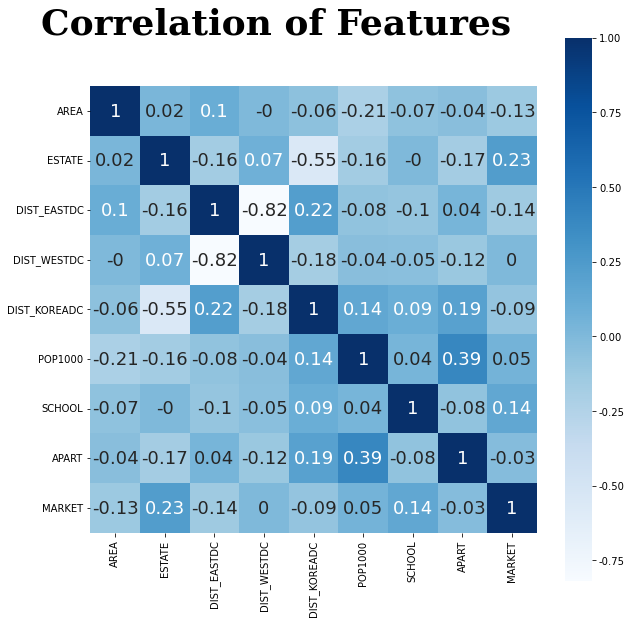

In [11]:
plt.figure(figsize = (10, 10))
corrmat = data.corr().round(2)
g = sns.heatmap(data = corrmat, annot = True, cmap = "Blues", square = True, annot_kws = {"size": 18})
g.text(-1, -1.065, "Correlation of Features", {"font": "serif", "size": 36, "weight": "bold"})
plt.show()